# Introduction

Welcome to the agile modelling python notebook. 

## What is a python notebook?

A python notebook allows you to run python code in a python environment. If you are running this notebook in Google Colab, the python notebook is running in a virtual machine in the cloud. 

## Overview

In this notebook, we will use a process called "Agile Modelling" to build a labelled dataset and from this build and incrementally improve a classifier for acoustic analysis using Perch embeddings. 
These are the steps we will take:

1. Installing and importing Perch and other requirements
2. Configuring the Perch agile modelling modules
3. Creating a database of embeddings
4. Searching your recordings for similarity to single queries
5. Building a machine learning classifier model from the search results
6. Searching your recordings based on their results in the classifier
7. Improving your classifier based on these results


# Installing and importing perch and dependencies

You are running this notebook in a python environment. We need to add the Perch package to this environment. We do this by running the `pip install` command below. You only need to do this once, however if you are running this notebook in the cloud on Google Colab, your session is only ephemaral. You need to rerun his this cell after disconnecting. 

After we have the python packaeges installed, we import them.

In [15]:
!pip install git+https://github.com/QutEcoacoustics/perch.git@0a5b6a88e4e63c6ee8a5b49337a77446be8666f3 python-dotenv

/home/administrator/mambaforge/envs/perch_env_10/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/QutEcoacoustics/perch.git (to revision 0a5b6a88e4e63c6ee8a5b49337a77446be8666f3) to /tmp/pip-req-build-5o_bkz0x
  Running command git clone --filter=blob:none --quiet https://github.com/QutEcoacoustics/perch.git /tmp/pip-req-build-5o_bkz0x
  Running command git rev-parse -q --verify 'sha^0a5b6a88e4e63c6ee8a5b49337a77446be8666f3'
  Running command git fetch -q https://github.com/QutEcoacoustics/perch.git 0a5b6a88e4e63c6ee8a5b49337a77446be8666f3
  Running command git checkout -q 0a5b6a88e4e63c6ee8a5b49337a77446be8666f3
  Resolved https://github.com/QutEcoacoustics/perch.git to commit 0a5b6a88e4e63c6ee8a5b49337a77446be8666f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chirp: filename=chirp-0.1.0-py3-none-any.whl size=6435688 sha256=f5c97dd4a63899133f507d451bfce09579a36b32957b08d0a1b6f90dd92a91f1
  Stored in directory: /home/administrator/.cache/pip/wh

In [16]:
#@title Imports. { vertical-output: true }
from pathlib import Path
from chirp.projects.agile2.agile_modeling_state import agile2_config, agile2_state, download_embeddings, Helpers

# Linking to google drive

We will need somewhere to read and write files. This colab environment where the notebook is running does not persist between sessions, so we will link to google drive for access to persistent storage. 

In [17]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    print("colab not available")

colab not available


# Configuration

Here we set some configuration for names and local filepaths and initialize our agile modeling workflow.

Your Ecosounds "auth_token" can be found by logging in to https://www.ecosounds.org, then clicking on your profile picture in the top left. You can copy your auth token from this profile page. 

In [18]:
from pathlib import Path

config = agile2_config()

config.search_dataset_name="search_dataset" #@param {type:'string'}
config.annotator_id="phil" #@param {type:'string'}


# If you followed the above instructions for creating a shortcut to the Drive folder, 
# you should be able to navigate to this directory in the left hand "Files" menu 
# in this Colab (indicated by the Folder icon on the far left menu).

base_folder = '/content/drive/My Drive/' 
base_folder = '/phil/esa2024/powerful_owl_subset/' 

# This is the location on google drive that this tutorial will use to save data.
working_folder = base_folder + 'esa2024_data/'

config.db_path = working_folder + 'db/db.sqlite'
config.embeddings_folder = working_folder + 'embeddings/'
config.labeled_examples_folder = working_folder + 'labeled_examples/'
config.models_folder = working_folder + 'models/'
config.predictions_folder = working_folder + 'predictions/'

#config.from_json("../../../local/esa/agile_configs/yellow_bellied_glider.json")
#config.from_json("../../../local/esa/agile_configs/powerful_owl_subset.json")

Path(config.labeled_examples_folder).mkdir(exist_ok=True, parents=True)

agile = agile2_state(config)

### Configuring access to your Ecosounds project

We will be loading audio from Ecosounds. If working with a private Ecosounds project, we need to provide the Ecosounds auth token associated with your ecosounds account. 

**Note: if you are using one of the demo sets, you can skip this step**

To find your ecosounds token, go to https://www.ecosounds.org/my_account and in the bottom left, click on the button to copy the token. 

Because this is a secret, we should avoid saving it in plain text in the notebook, so we will set it up in an environment variable. Depending on where you are running this notebook, do one of the following (if you are not sure, just run the cell below and it will tell you).

If working in **colab**, do the following:
1. On the right, click on the key icon to open the "secrets" tab.
2. Click "Add new secret"
3. Under "Name" put the text `BAW_AUTH_TOKEN` (without quotes)
4. Under "Value" paste the token you copied from Ecosounds

If working in **jupyter running locally**, do the following
1. In the working directory create a file named `.env`
   - The working directory is probably the directory where you launched the notebook. If you are not sure, run the cell below and it will tell you. 
2. In this .env file, put the line `BAW_AUTH_TOKEN=abc123xyz` (replace the abc123xyz with the token you copied from Ecosounds)



In [19]:
import os, sys
auth_token = None

try:
    from google.colab import userdata
    auth_token = userdata.get('BAW_AUTH_TOKEN')
    print("Got auth token from colab secrets")

except ModuleNotFoundError:
    from dotenv import load_dotenv, find_dotenv
    env_file = find_dotenv()
    if not env_file:
        print(f"No .env file found in the working directory {os.getcwd()}. \nFollow the local Jupyter instructions above to create one.")
    else:
        load_dotenv(override=True)
        auth_token = os.getenv('BAW_AUTH_TOKEN')
        if auth_token:
            print(f"Got auth token from .env file {env_file}")
        else:
            print("BAW_AUTH_TOKEN env variable not found in your .env file. Follow the local Jupyter instructions above to set it")
    
except userdata.SecretNotFoundError:
        print("No BAW_AUTH_TOKEN secret found, please follow the colab instructions above to set it")

if auth_token:
    if config.baw_config.get('auth_token'):
        print("Overwriting config auth token with new value")
    config.baw_config['auth_token'] = auth_token
elif config.baw_config.get('auth_token'):
    print("Auth token not loaded, but already in config")
else:
    print("No auth token set")


config.baw_config['domain'] = 'api.ecosounds.org'

No .env file found in the working directory /home/administrator/GitHub/QutEcoacoustics/perch/chirp/projects/agile2. 
Follow the local Jupyter instructions above to create one.
No auth token set


# Create embeddings database

Here we retrieve the a file of embeddings for each of the recordings that we will be searching in and put them in the right format for working with them. 

The `search_set_id` is the id of your search set, preprepared on Ecosounds. 

If you have uploaded audio for this workshop, you will have been given an id for that search set. 

You can also use one of the following public search sets

1. `yellow_bellied_glider`
2. `powerful_owl`
3. `powerful_owl_subset` (a smaller dataset that takes less time to prepreocess and search through)


In [20]:
# Download audio embeddings to the working folder
# this might take a while

search_set_id = 'powerful_owl_subset' #@param {type:'string'}
#search_set_id = 'powerful_owl_subset' #@param {type:'string'}


download_embeddings(search_set_id, config.embeddings_folder)

Embeddings already downloaded and extracted at /mnt/c/Users/Administrator/Documents/phil/esa2024/powerful_owl_subset/esa2024_data/embeddings.


Button(description='Download again and overwrite existing embeddings?', layout=Layout(width='auto'), style=But…

In [21]:
# using the downloaded embeddings, create a database of embeddings.
# This database links labels to embeddings so we can train our classifier
# this might take a while
agile.create_database(config.embeddings_folder)

DB path already exists at /mnt/c/Users/Administrator/Documents/phil/esa2024/powerful_owl_subset/esa2024_data/db/db.sqlite.


Button(description='Delete Existing Database and create it again?', layout=Layout(width='auto'), style=ButtonS…

In [22]:
agile.initialize()

Initializing DB...
DB initialized with 37632 embeddings.


# Search

Here, we take a single example and find the examples in our search set which most closely match that example. This is a way to get started with a labelled training set.

If you have short examples of your target call, copy them into the labeled_examples_folder and then run the following cell to check that they are accessible. 

In [23]:
# Put your labelled examples in a folder on your mounted Google Drive, 
# Run this cell to list the audio files in that folder

audio_files = Helpers.list_audio_files(config.labeled_examples_folder)

Found 3 audio files in /phil/esa2024/powerful_owl_subset/esa2024_data/labeled_examples
0: /phil/esa2024/powerful_owl_subset/esa2024_data/labeled_examples/conservation_ecology_centre_649_232856_20120729_091043_5_0.wav
1: /phil/esa2024/powerful_owl_subset/esa2024_data/labeled_examples/gympie_np_1192_331564_20150622_195001_22_0.wav
2: /phil/esa2024/powerful_owl_subset/esa2024_data/labeled_examples/quinzeh_park_4515_2569786_20200812_214325_7_0.wav


Next, load a query audio. You can enter the item number for one of the examples listed in the previous cell output. Or alternatively you can enter a a URL, filepath, or Xeno-Canto ID in the form `xc777802`.

This will display the example and allow you to select the 5-second portion of it to use. Note: if your example is too long, this can make the selection of the 5-second segment a bit more difficult. 

In [24]:
#@title Load query audio. { vertical-output: true }


#@markdown The `query` can be an item number in your labeled examples folder, or
#@markdown  a URL, filepath, or Xeno-Canto ID
#@markdown (like `xc777802`, containing an Eastern Whipbird (`easwhi1`)).
query = '2' # @param {type:'string'}


agile.display_query(query)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='offset_s', max=7.0), Output…

Next, we generate an embedding for the 5-second example and then compare it against the embeddings in the database to find similar 5-second clips from your search dataset. 

I0000 00:00:1733291512.589899 1986411 service.cc:146] XLA service 0x55af71d066d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733291512.589972 1986411 service.cc:154]   StreamExecutor device (0): Host, Default Version
W0000 00:00:1733291513.112362 1986411 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1733291516.293023 1986411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


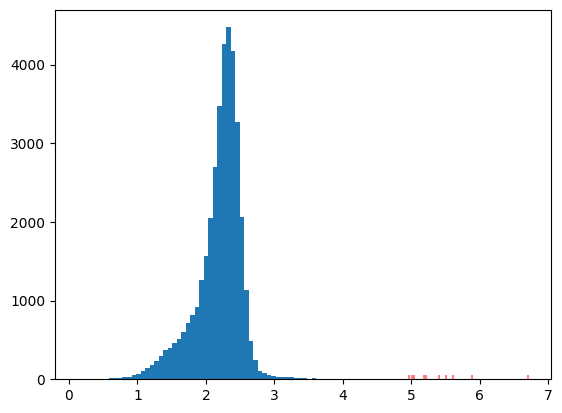

In [25]:

#@markdown Number of results to retrieve.
num_results = 10  #@param
#@markdown Number of (randomly selected) database entries to search over.
sample_size = None  #@param
#@markdown When margin sampling, target this logit.
target_score = None  #@param

agile.embed_query()

#agile.search_with_query(query_label, num_results, sample_size, target_score)
agile.search_with_query(
        num_results=num_results,
        sample_size=sample_size,
        target_score=target_score)

Next, look at some of these search results. For each example you can look at a spectrogram and listen to the audio, then apply a positive label if it is the target class, and negative if it's not the target class.  Set the `query_label` variable to define the label that this button will add to these embeddings in your database. 

Click the label once to turn it green for a positive label, and twice to turn it orange for a negative label. Leave it unclicked if you don't want to apply any label to the example (i.e. don't add it to your labelled training set). 

Note: loading the spectrograms can sometimes fail. If you see some examples that failed to load, try running the cell a second time before starting your labelling. 

Page 2 of 2
--------------------------------------------------------------------------------



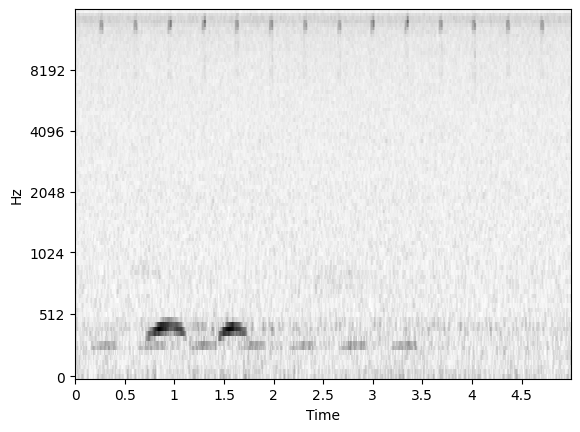

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2645866/original
offset_s     : 25.00
rank         : 10
score        : 6.71


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


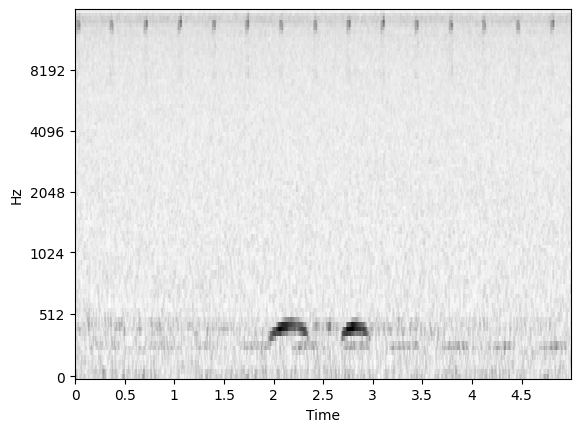

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2645866/original
offset_s     : 15.00
rank         : 11
score        : 5.89


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


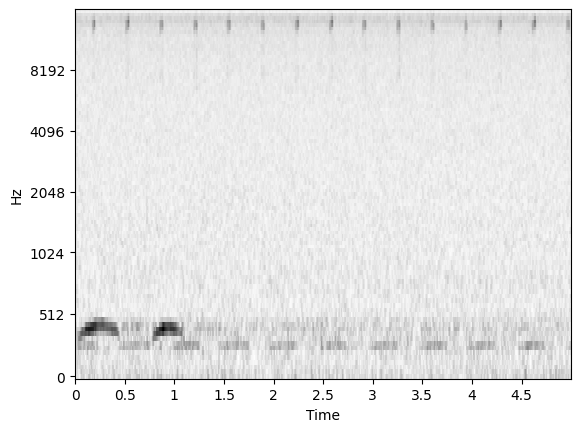

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2645866/original
offset_s     : 50.00
rank         : 12
score        : 5.60


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


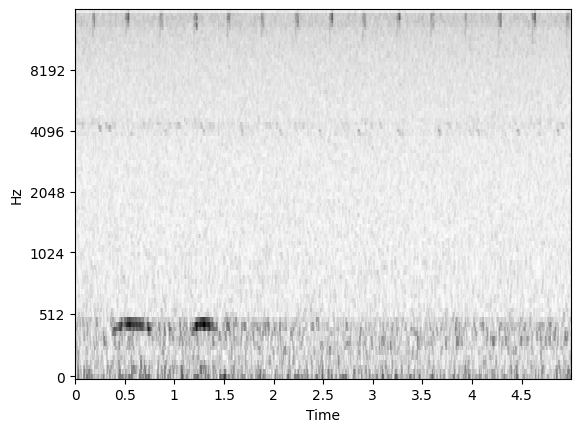

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2596117/original
offset_s     : 50.00
rank         : 13
score        : 5.51


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


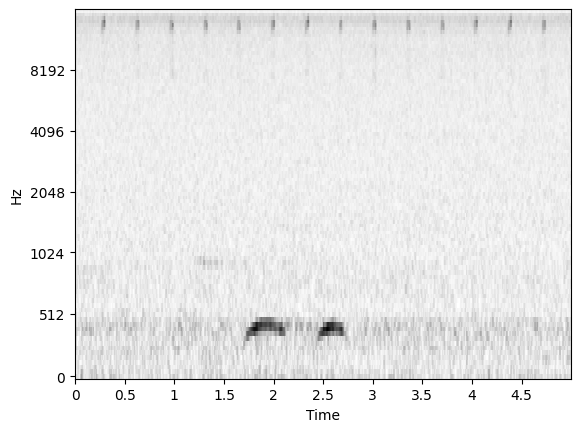

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2645866/original
offset_s     : 40.00
rank         : 14
score        : 5.40


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


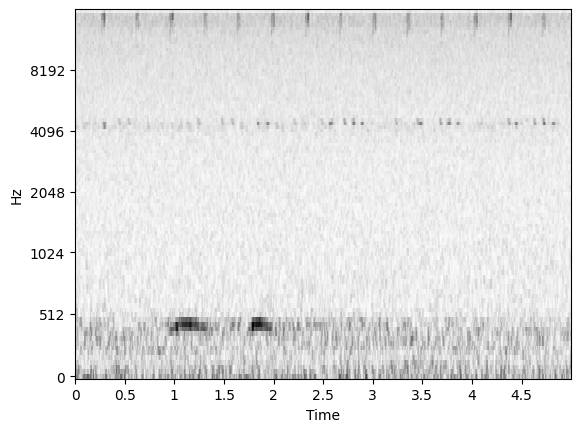

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2596117/original
offset_s     : 40.00
rank         : 15
score        : 5.22


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


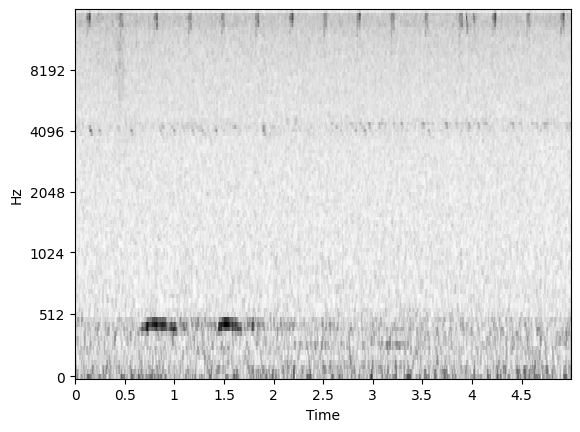

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2596117/original
offset_s     : 5.00
rank         : 16
score        : 5.19


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


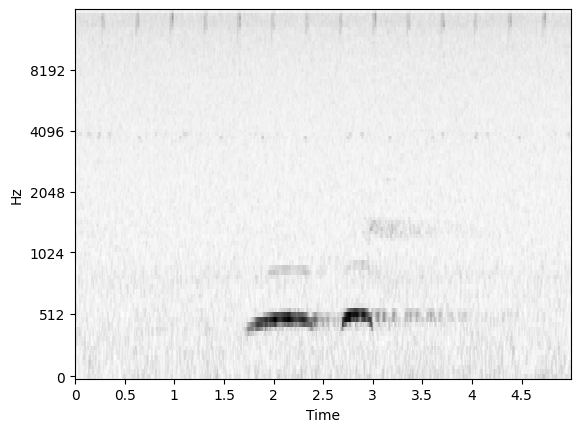

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2599227/original
offset_s     : 40.00
rank         : 17
score        : 5.03


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


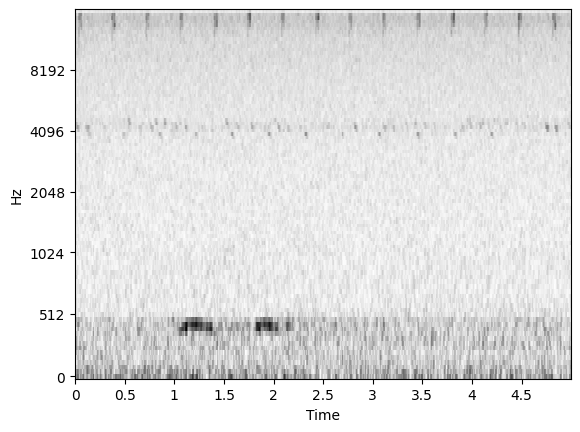

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2596117/original
offset_s     : 30.00
rank         : 18
score        : 5.02


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------


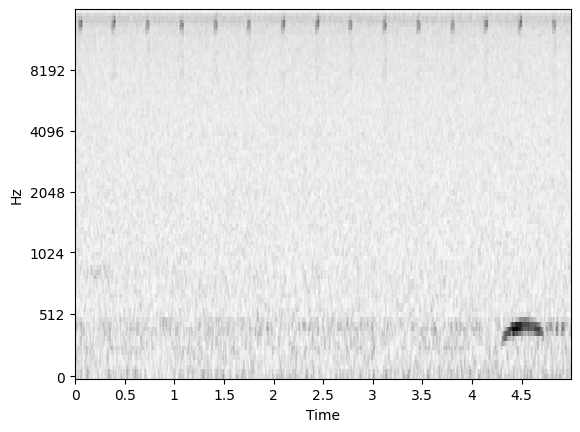

dataset name : search_dataset
source uri   : https://api.ecosounds.org/audio_recordings/2645866/original
offset_s     : 30.00
rank         : 19
score        : 4.97


GridspecLayout(children=(Button(description='powerful_owl', layout=Layout(grid_area='widget001'), style=Button…


--------------------------------------------------------------------------------
Page 2 of 2


Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [ ]:
#@markdown Our target call-type label
query_label = 'powerful_owl'  #@param {type:'string'}

agile.display_search_results(query_label)

When you have finished labelling, run the following cell to save these newly labelled examples to the database. 

In [27]:
#@title Save data labels. { vertical-output: true }

agile.save_labels()


new_lbls:  10

prev_lbls:  0
Label counts:
powerful_owl: 10 positive, 0 negative


(0, 10)

Repeat the above steps with a few different audio queries. If your target species has multiple call types, it would be a good idea to search for at least one of each call type. 

# Classify

Now that we have labelled a number of our embedded audio clips in the search set, we have what we need to train and evaluate a classifier. 

This classifier is a statistical model. It is trained through an algorithm called Gradient Descent. This process requires setting some parameters.

For the most part, you the default values for all of these will work fine. You might want to start by leaving the defaults, then experiment later to see if you can get any improvements. 

1. **Target Labels**: If you have put more than one class into your embeddings database, and you don't want to build the model to include all of these, list the ones you do want to include

The following are hyperparameters of the gradient descent algorithm. The algorithm looks at 'batches' of examples and updates the model's parameters a little after each batch. 

2. **learning_rate**: How much to update by after each batch
3. **batch_size**: How many examples to include in each batch (generally leave it pretty high and only reduce if you have RAM problems)
4. **num_steps**: How many times to look at all the batches. When you train, you will see the "loss" decreasing as it learns. The num_steps should ideally be set so that arrives at the last step just after it stops improving. 

The following are to do with the labelled data inputs. 

5. **train_ratio**: A random subset of the labelled audio is not used to train the model, but instead is used to test the model. This is so we know roughly how well the model does on classifying examples that it has never seen before. 
3. **weak_neg_weight**: In your database we have a lot of audio, most of which is probably not your target. By taking some random clips from your unlabelled audio and treating them as negative examples, we can train on a wider variety of negative examples than what has been explicitly labelled as negative. However, because we don't know for sure that this process didn't choose a positive example by chance, we give each one less importance in the training. 
6. **weak_negatives_batch_size**: How many of these randomly chosen examples to include for each batch (on top of the number in the strongly labelled batch)

In [ ]:
#@title Classifier training. { vertical-output: true }

#@markdown Set of labels to classify. If None, auto-populated from the DB.
target_labels = None  #@param

learning_rate = 1e-3  #@param
num_steps = 20  #@param
batch_size = 128  #@param

train_ratio = 0.8  #@param
weak_neg_weight = 0.05  #@param
weak_negatives_batch_size = 128  #@param

from chirp.projects.agile2 import classifier_data
import numpy as np
data_manager = classifier_data.AgileDataManager(
    target_labels=target_labels,
    db=agile.db,
    train_ratio=train_ratio,
    min_eval_examples=1,
    batch_size=batch_size,
    weak_negatives_batch_size=weak_negatives_batch_size,
    rng=np.random.default_rng(seed=5))


agile.train_classifier(target_labels, learning_rate, weak_neg_weight, num_steps, train_ratio, batch_size, weak_negatives_batch_size)




Now that we have a trained classifier, we can follow the same process as for the single example query. We search the database for more examples using the classifier, label them, then re-train the classifier with the new examples. 

The classifier outputs a score for each example in the search set. It believes anything above zero belongs to your target class, and anything below doesn't. 

When searching using the classifier, we can look for examples with the highest score by setting `target_score` to `None`.  This might get us more positive examples but these probably won't improve the classifier much, because they already have a high score. More useful is to search for those examples that the classifier is least sure about, by setting `target_score` to `0`.  Try setting the target score to None, 0 and possibly some other values depending on how many positive examples come back from each of those. 

In [ ]:
#@title Review Classifier Results. { vertical-output: true }
#@markdown Our target call-type label
query_label = 'powerful_owl'  #@param {type:'string'}
#@markdown Number of results to retrieve.
num_results = 10  #@param
#@markdown Number of (randomly selected) database entries to search over.
sample_size = None  #@param
#@markdown When margin sampling, target this logit.
target_score = 0  #@param

agile.search_with_classifier(query_label, num_results, sample_size, target_score)

In [ ]:
agile.display_search_results(query_label)


In [ ]:
#@title Save data labels. { vertical-output: true }

agile.save_labels()

# Saving your classifier and running inference

The trained classifier consists of the following elements
1. The *weights* of the model (how to multiply and add the embedding values together to produce higher scores for the examples of the target class than other examples), which were learned during training. 
2. The model *bias* (how to shift the scores so that scores for positive examples are positive and vice-versa), also learned during training. 
3. The list of labels (class names) corresponding to the output scores
4. Some metadata related to the model that created the embeddings, so that if the classifier is used on new audio, we make sure to embed in a compatible way. 

With this information, the classifier can be saved and used on other search sets later on. 

In [ ]:
classifier_name = 'powerful_owl_v01'  #@param {type:'string'}

classifier_path = Path(config.models_folder) / f'{classifier_name}.json'

classifier_path.parent.mkdir(exist_ok=True, parents=True)

agile.classifier.save(classifier_path)

We can also run the model over all of the search dataset and save the results to a csv. Specify:
1. The csv filename to save the results to
2. The threshold. Anything above the threshold for the target labels will be saved. Typically this would be zero to save anything the classifier believes is the target class
3. Which labels to include. Leave it as None to include all the labels you trained for. 

In [ ]:
output_filename = 'powerful_owl_v01_output.csv'  #@param {type:'string'}

threshold=0.0
labels = None

output_filepath = Path(agile.config.predictions_folder) / output_filename
Path(output_filepath).parent.mkdir(parents=True, exist_ok=True)
agile.run_inference(output_filepath)